In [1]:
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

#library for Entropy calculation
from scipy.stats import entropy

#librery for Calinski-Harabasz score calculation
from sklearn.metrics import calinski_harabasz_score

#librery for davies_bouldin score calculation
from sklearn.metrics import davies_bouldin_score

from gap_statistic import OptimalK

In [2]:
from sklearn.metrics import pairwise_distances

#function for dunn_index score calculation
def dunn_index(X, labels):
    unique_labels = np.unique(labels)
    min_intercluster_distance = np.inf
    max_intracluster_diameter = -np.inf

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i_points = X[labels == unique_labels[i]]
            cluster_j_points = X[labels == unique_labels[j]]
            
            # Calculate the minimum distance between clusters
            intercluster_distance = np.min(pairwise_distances(cluster_i_points, cluster_j_points))
            min_intercluster_distance = min(min_intercluster_distance, intercluster_distance)

        # Calculate the maximum intra-cluster diameter
        intracluster_diameter = np.max(pairwise_distances(X[labels == unique_labels[i]]))
        max_intracluster_diameter = max(max_intracluster_diameter, intracluster_diameter)

    return min_intercluster_distance / max_intracluster_diameter

Silhouette Scores:
0.9555705730618019
0.9111894290389946
0.7806405508643918
0.5776329963152718
0.45945048229756774
0.3874967323036958
0.3653915655860851
0.3415050628363792
0.33115265494360857
0.3283532983890506

Entropy Scores:
1.0
1.0
1.0
1.0
0.9984730898903077
0.9996508396313203
0.9990649315776106
0.9986030202378096
0.9996508396313203
0.9991659615315873

Calinski Harabasz Scores:
199260.8283350221
49893.1465300441
8186.534742373617
2146.6189127462803
1172.5533864130891
803.1183688149634
687.1800219148497
596.5144877486807
590.765974476827
564.2526618085254

Davies-Bouldin Scores:
0.06285658910546564
0.12565404260579238
0.31101213975958475
0.6051740251840623
0.8242773938876627
0.9900531249971496
1.0559665998655428
1.1330300773959123
1.1538195127192574
1.1659421204232847

Dunn-Index Scores:
4.6578812684261575
2.05637704296678
0.3552341676108256
0.019058748389450937
0.010647078038708575
0.008107582603335309
0.0055260718934726045
0.003515014380655728
0.005462628956927215
0.00705042944650

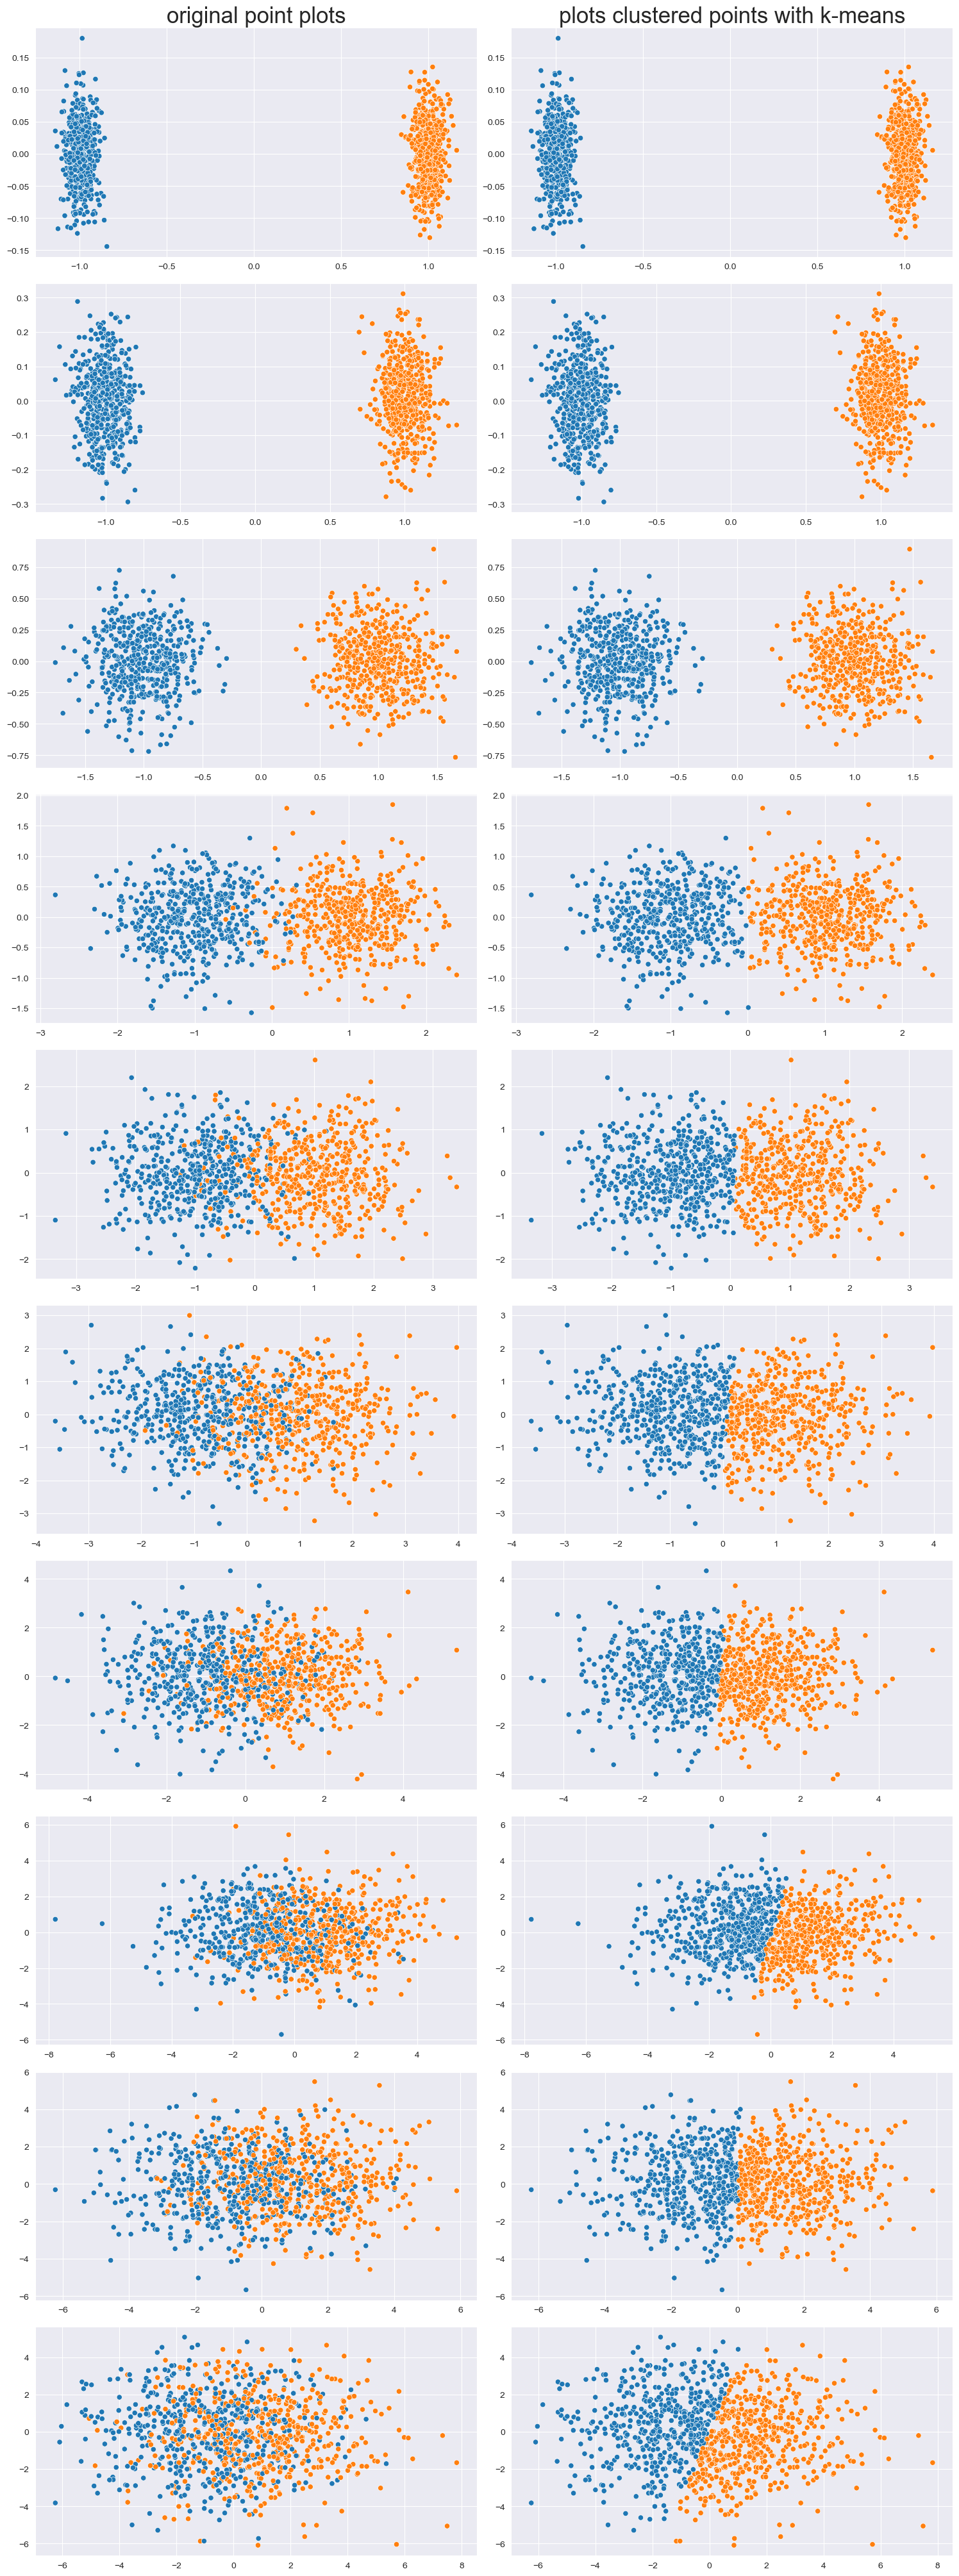

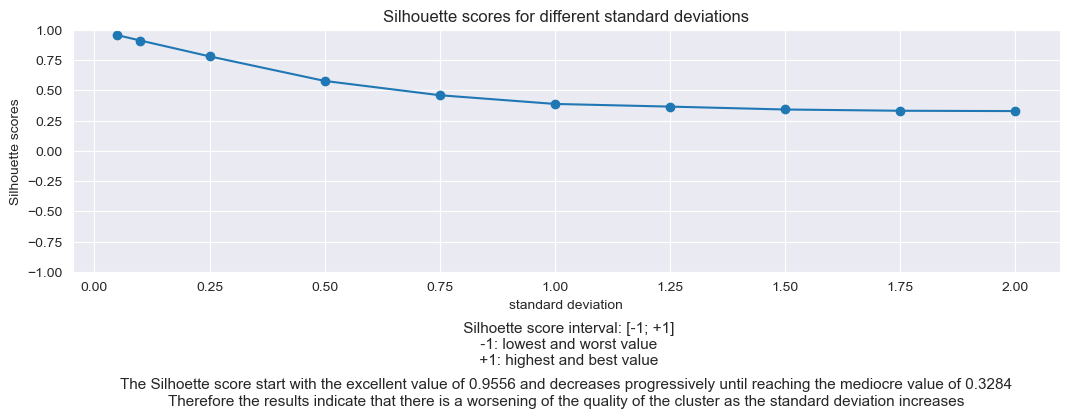

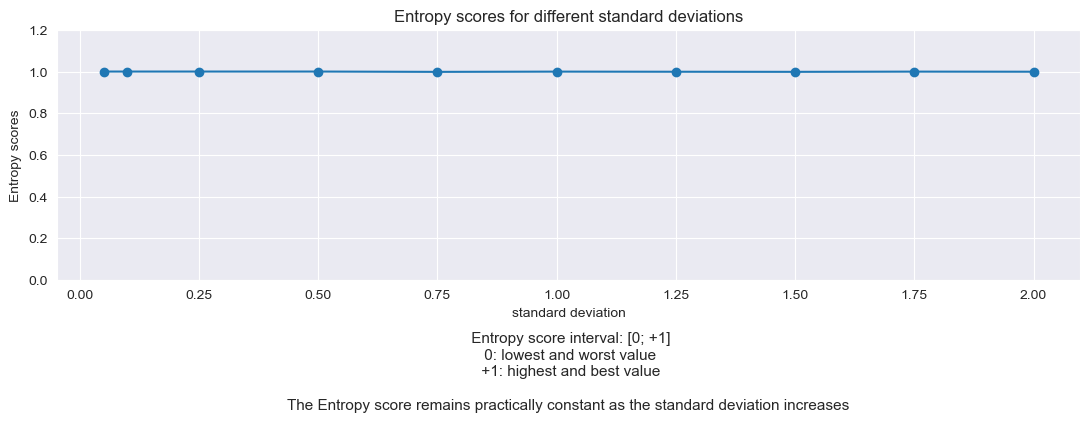

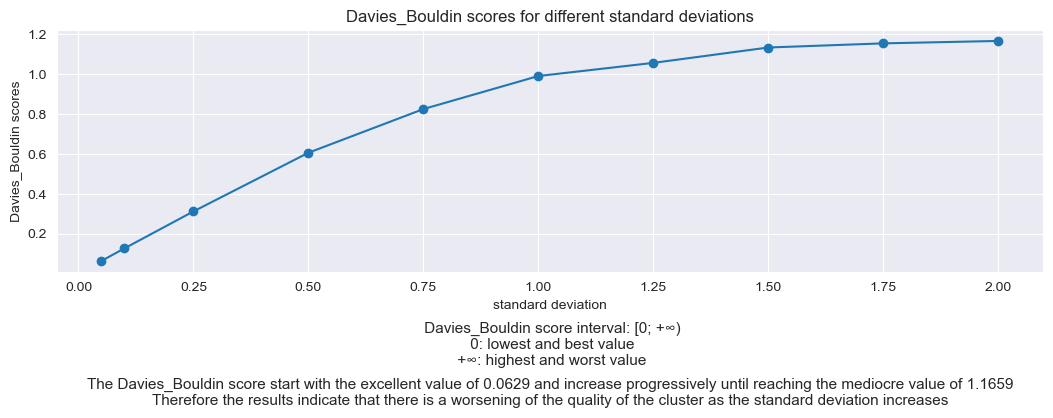

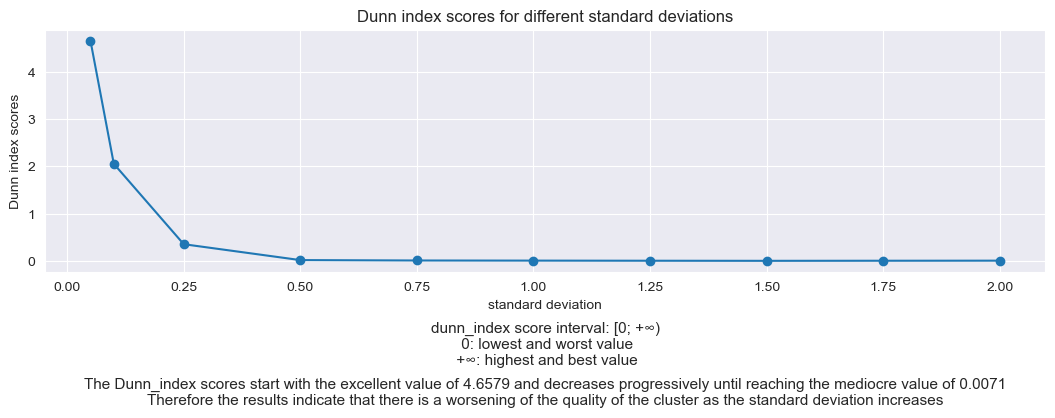

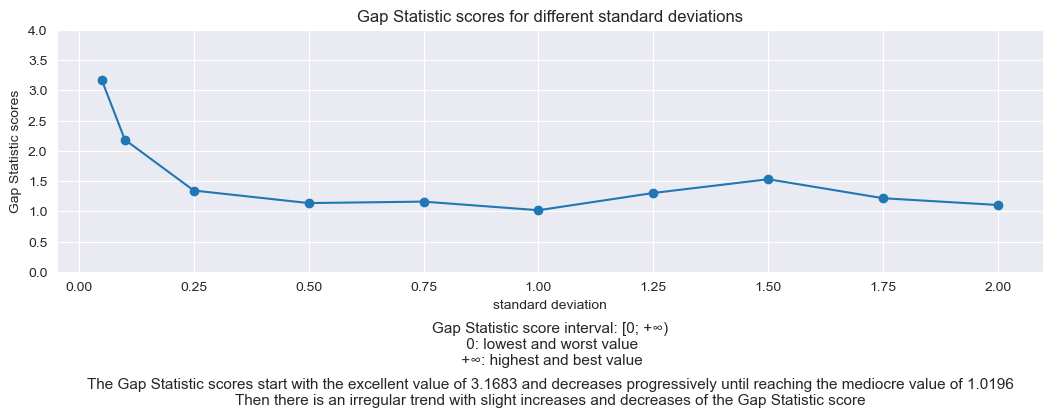

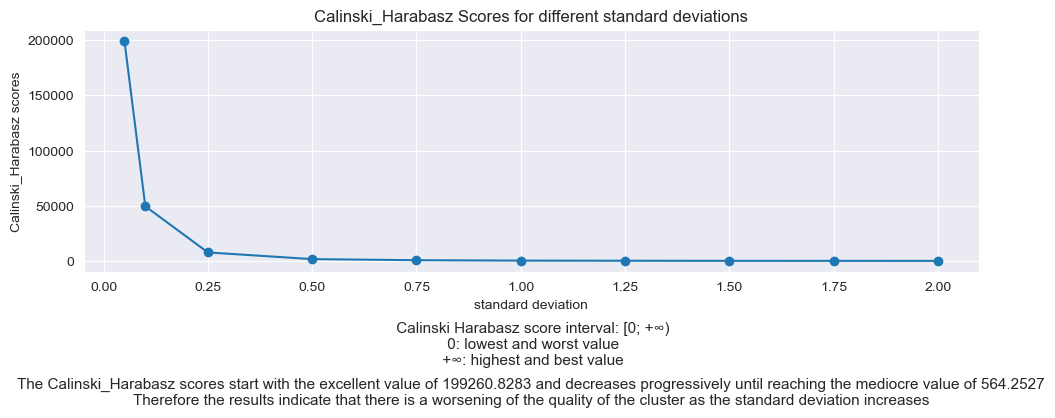

In [6]:
# Array for metric values
silhouette_scores = []  
entropy_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
dunn_index_scores = [] 
gap_scores = []

# Standard deviation
sds = [0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]

'''
# Generate random Gap Statistic values for comparison
random_gap_scores = []

# Numero di iterazioni per generare dati casuali
num_iterations = 10

for s in sds:
    gap_scores_iteration = []
    for _ in range(num_iterations):
        # Genera dati casuali
        X_random, _ = make_blobs(n_samples=1000, centers=[[0,0]], cluster_std=s)
        
        # Calcola la Gap Statistic
        optimal_k = OptimalK(parallel_backend='joblib')
        n_clusters = optimal_k(X_random, cluster_array=np.arange(1, 15))
        gap_df = optimal_k.gap_df
        optimal_gap_statistic = gap_df.loc[gap_df.gap_value.idxmax(), 'gap_value']
        gap_scores_iteration.append(optimal_gap_statistic)
    
    # Calcola la media dei valori casuali della Gap Statistic per questa deviazione standard
    mean_gap_score = np.mean(gap_scores_iteration)
    random_gap_scores.append(mean_gap_score)

# Ora hai i valori casuali della Gap Statistic per confrontarli con quelli veri
print("Valori casuali della Gap Statistic:")
print(random_gap_scores)
'''

fig, axs = plt.subplots(10,2, figsize=(15,40))
sns.set_style("darkgrid")
fig.tight_layout()

r = 0
c = 0
c2= 1

for s in sds:
    X, y = make_blobs(n_samples=1000, centers=[[-1,0],[1,0]], cluster_std=s)
    if r==0:
        scatter=sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[r,c])
        scatter.set_title('original point plots', fontsize=25)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[r,c])
    axs[r,c].get_legend().remove()
    
    data = pd.DataFrame(np.zeros((1000, 3)))
    data.iloc[:, [0,1]] = X
    data.iloc[:, 2] = y
    data.to_csv("cluster_" + str(s) + ".csv")

    km = KMeans(n_clusters=2, n_init=1, random_state=0)
    km.fit(X)
    l = km.labels_
    cs = km.cluster_centers_
    if cs[0,0] > cs[1,0]:
        l = [1 if x == 0 else 0 for x in l]
    
    # Silhouette calculation
    silhouette_avg = silhouette_score(X, l)
    silhouette_scores.append(silhouette_avg)
    
    # Entropy calculation
    entropy_val = entropy(np.bincount(l) / len(l), base=2)
    entropy_scores.append(entropy_val)
    
    # Calinski-Harabasz index calculation
    calinski_harabasz_index = calinski_harabasz_score(X, l)
    calinski_harabasz_scores.append(calinski_harabasz_index)
    
    # Davies-Bouldin calculation
    davies_bouldin_avg = davies_bouldin_score(X, l)
    davies_bouldin_scores.append(davies_bouldin_avg)
    
    # Dunn index calculation
    dunn_score = dunn_index(X, l)
    dunn_index_scores.append(dunn_score)
    
    # Gap Statistic calculation
    optimal_k = OptimalK(parallel_backend='joblib')
    n_clusters = optimal_k(X, cluster_array=np.arange(1, 15))
    gap_df = optimal_k.gap_df
    optimal_gap_statistic = gap_df.loc[gap_df.gap_value.idxmax(), 'gap_value']
    gap_scores.append(optimal_gap_statistic)

    if r==0:
        scatter2=sns.scatterplot(x=X[:,0], y=X[:,1], hue=l, ax=axs[r,c2])
        scatter2.set_title('plots clustered points with k-means', fontsize=25)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=l, ax=axs[r,c2])
    axs[r,c2].get_legend().remove()        
    
    r=r+1

# Print metric arrays
print("Silhouette Scores:")
for score in silhouette_scores:
    print(score)

print("\nEntropy Scores:")
for score in entropy_scores:
    print(score)
    
print("\nCalinski Harabasz Scores:")
for score in calinski_harabasz_scores:
    print(score)

print("\nDavies-Bouldin Scores:")
for score in davies_bouldin_scores:
    print(score)
    
print("\nDunn-Index Scores:")
for score in dunn_index_scores:
    print(score)
    
print("\nGap Scores:")
for score in gap_scores:
    print(score)

#print(optimal_k.gap_df .iloc[:,:3])

# Save metric values to a txt file
with open("metrics_values.txt", "w") as file:
    file.write("Silhouette Scores:\n")
    for score in silhouette_scores:
        file.write(str(score) + "\n")

    file.write("\nEntropy Scores:\n")
    for score in entropy_scores:
        file.write(str(score) + "\n")

    file.write("\nCalinski Harabasz Scores:\n")
    for score in calinski_harabasz_scores:
        file.write(str(score) + "\n")

    file.write("\nDavies-Bouldin Scores:\n")
    for score in davies_bouldin_scores:
        file.write(str(score) + "\n")

    file.write("\nDunn-Index Scores:\n")
    for score in dunn_index_scores:
        file.write(str(score) + "\n")

    file.write("\nGap Scores:\n")
    for score in gap_scores:
        file.write(str(score) + "\n")

# Plot of Silhouette variations
plt.figure(figsize=(11, 5))
plt.plot(sds, silhouette_scores, marker='o')
plt.title('Silhouette scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Silhouette scores')
plt.grid(True)
plt.ylim(-1, 1)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_1/variazioni_Silhouette_1.png'
text = ' Silhoette score interval: [-1; +1]\n -1: lowest and worst value\n +1: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = 'The Silhoette score start with the excellent value of '+ "{:.4f}".format(silhouette_scores[0]) + ' and decreases progressively until reaching the mediocre value of '+ "{:.4f}".format(silhouette_scores[-1]) +'\nTherefore the results indicate that there is a worsening of the quality of the cluster as the standard deviation increases'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Entropy variations
plt.figure(figsize=(11, 5))
plt.plot(sds, entropy_scores, marker='o')
plt.title('Entropy scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Entropy scores')
plt.grid(True)
plt.ylim(0, 1.2)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_1/variazioni_Entropy_1.png'
text=' Entropy score interval: [0; +1]\n 0: lowest and worst value\n +1: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = 'The Entropy score remains practically constant as the standard deviation increases'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Davies_Bouldin variations
plt.figure(figsize=(11, 5))
plt.plot(sds, davies_bouldin_scores, marker='o')
plt.title('Davies_Bouldin scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Davies_Bouldin scores')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_1/variazioni_Davies_Bouldin_1.png'
text=' Davies_Bouldin score interval: [0; +∞)\n 0: lowest and best value\n +∞: highest and worst value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = 'The Davies_Bouldin score start with the excellent value of '+ "{:.4f}".format(davies_bouldin_scores[0]) +' and increase progressively until reaching the mediocre value of '+ "{:.4f}".format(davies_bouldin_scores[-1])+'\nTherefore the results indicate that there is a worsening of the quality of the cluster as the standard deviation increases'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Dunn_index variations
plt.figure(figsize=(11, 5))
plt.plot(sds, dunn_index_scores, marker='o')
plt.title('Dunn index scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Dunn index scores')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_1/variazioni_dunn_index_1.png'
text = 'dunn_index score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
text2 = 'The Dunn_index scores start with the excellent value of '+ "{:.4f}".format(dunn_index_scores[0]) +' and decreases progressively until reaching the mediocre value of '+ "{:.4f}".format(dunn_index_scores[-1])+'\nTherefore the results indicate that there is a worsening of the quality of the cluster as the standard deviation increases'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Gap Statistic variations
plt.figure(figsize=(11, 5))
plt.plot(sds, gap_scores, marker='o')
plt.title('Gap Statistic scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Gap Statistic scores')
plt.grid(True)
plt.ylim(0, 4)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_1/variazioni_gap_1.png'
text = 'Gap Statistic score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
text2 = 'The Gap Statistic scores start with the excellent value of '+ "{:.4f}".format(gap_scores[0]) +' and decreases progressively until reaching the mediocre value of '+ "{:.4f}".format(min(gap_scores))+'\nThen there is an irregular trend with slight increases and decreases of the Gap Statistic score'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()


# Plot of Calinski_Harabasz Scores variations
plt.figure(figsize=(11, 5))
plt.plot(sds, calinski_harabasz_scores, marker='o')
plt.title('Calinski_Harabasz Scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Calinski_Harabasz scores')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_1/variazioni_Calinski_Harabasz_1.png'
text=' Calinski Harabasz score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = 'The Calinski_Harabasz scores start with the excellent value of '+ "{:.4f}".format(calinski_harabasz_scores[0]) +' and decreases progressively until reaching the mediocre value of '+ "{:.4f}".format(calinski_harabasz_scores[-1])+'\nTherefore the results indicate that there is a worsening of the quality of the cluster as the standard deviation increases'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

fig.savefig("gaussians.png", facecolor="gray")

Silhouette Scores:
0.3438674412652773
0.34851745062320316
0.4321570508701087
0.4969480708783215
0.5236673002637073
0.5231770338185358

Entropy Scores:
0.9988339010532259
0.999107261904943
0.9333930737612746
0.9482102328088211
0.9593795191444577
0.9775696629057534

Calinski Harabasz Scores:
232.84604101170015
238.97790104784772
281.0543090934223
377.5125634095005
454.7914778141793
505.69498593279224

Davies-Bouldin Scores:
1.208771499761885
1.1906110774485672
1.0594174615126835
0.925802416480313
0.8398935005109184
0.8043264661462324

Dunn-Index Scores:
0.014737408903722795
0.009406161169058909
0.021262804003380913
0.022973836304669155
0.026919615168873923
0.0202996646094552

Gap Scores:
0.6548276223922642
0.6011052768463452
0.5889480357996404
0.6509829971353138
1.0049395692209397
1.0381100813089925


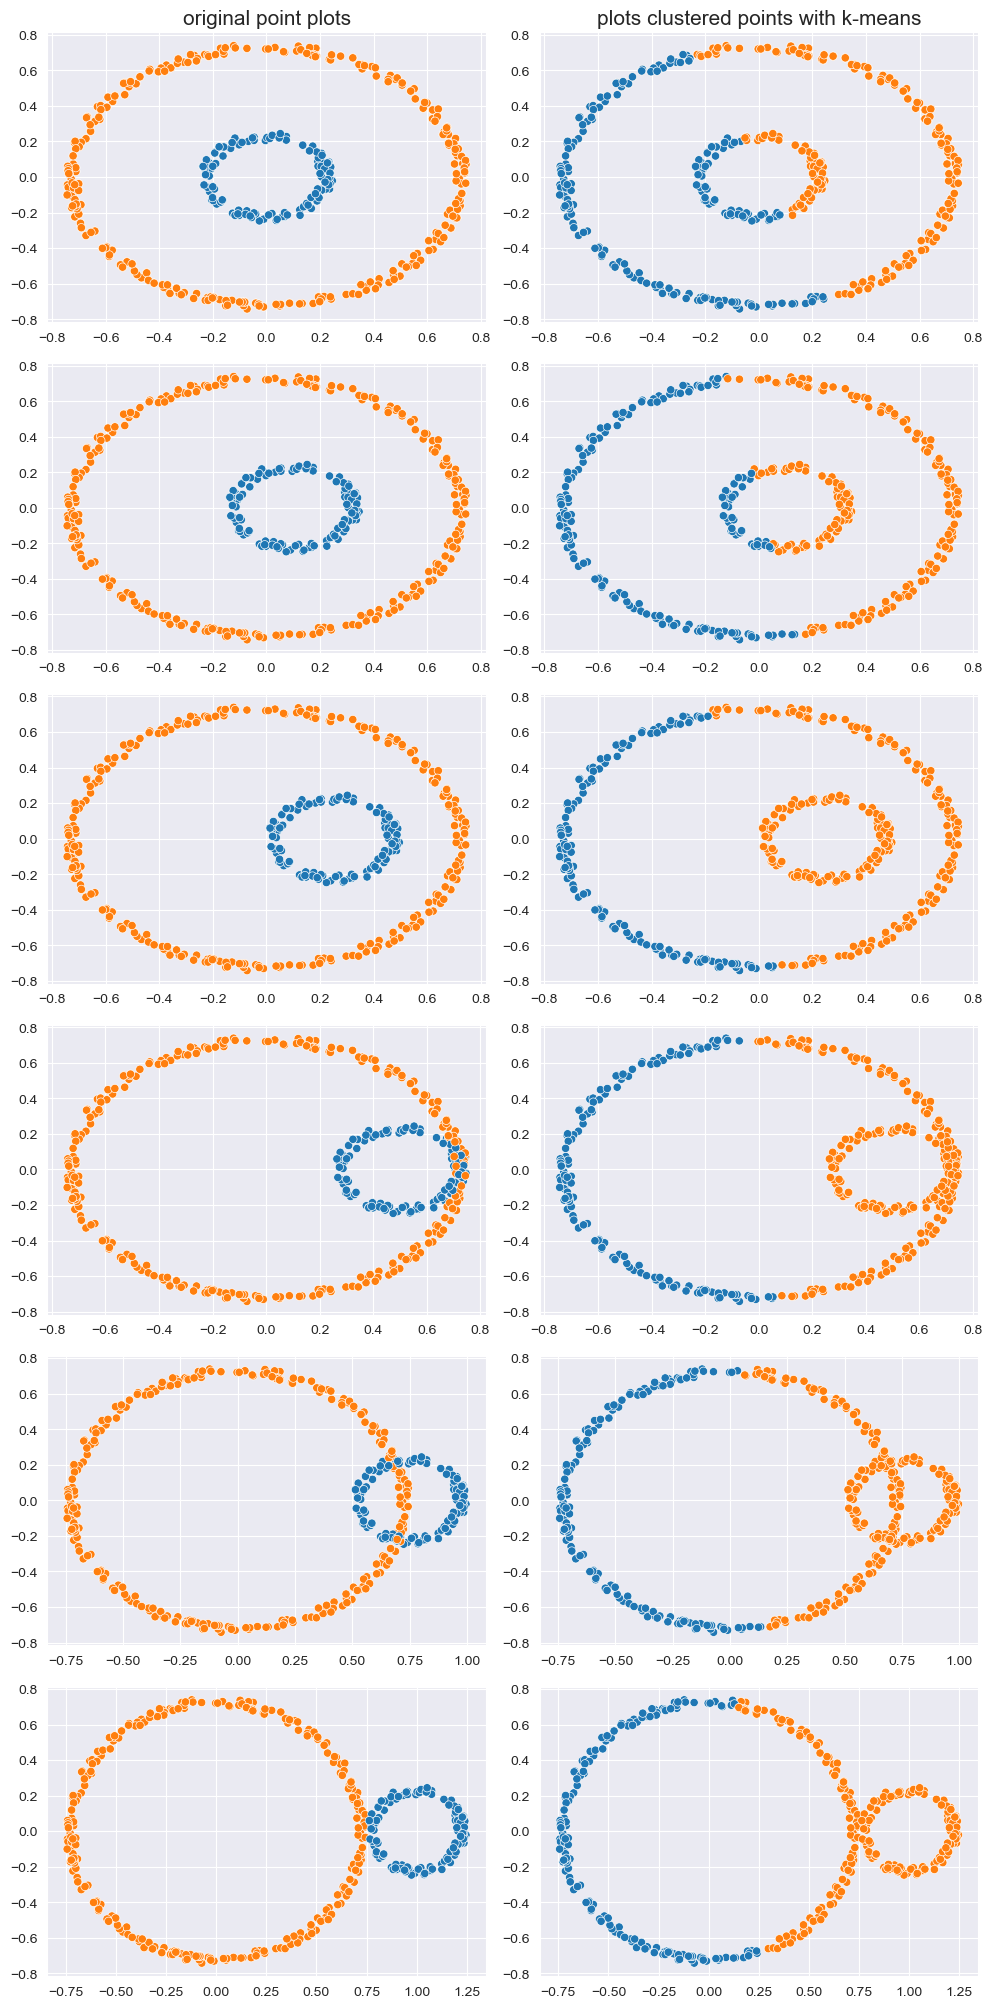

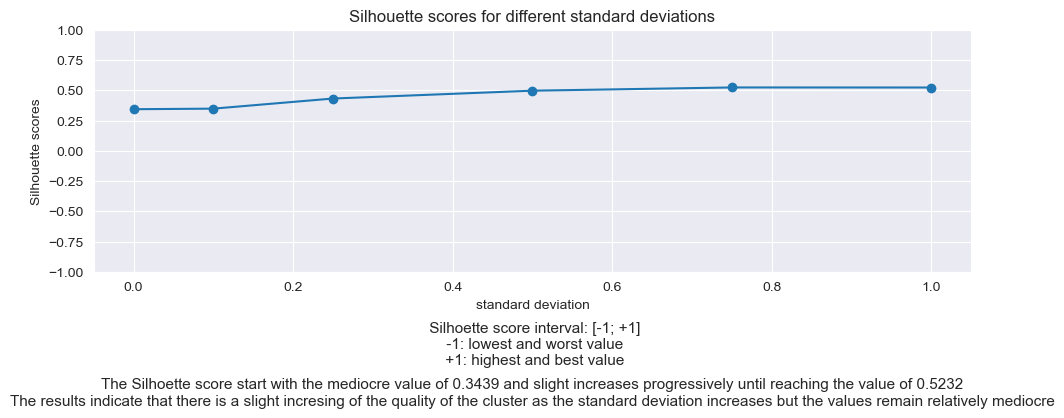

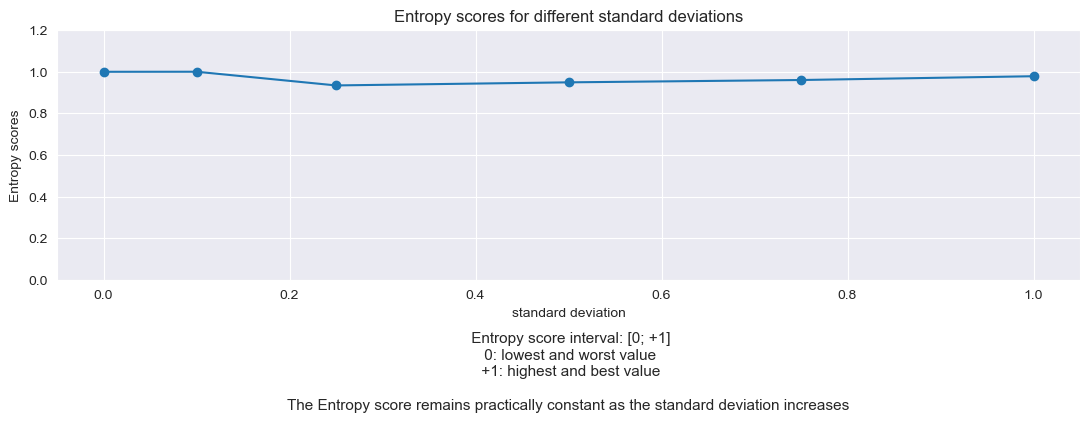

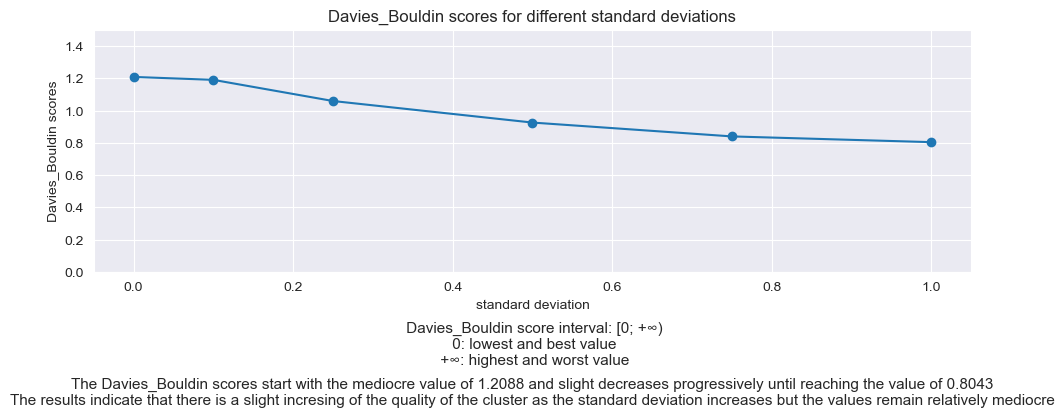

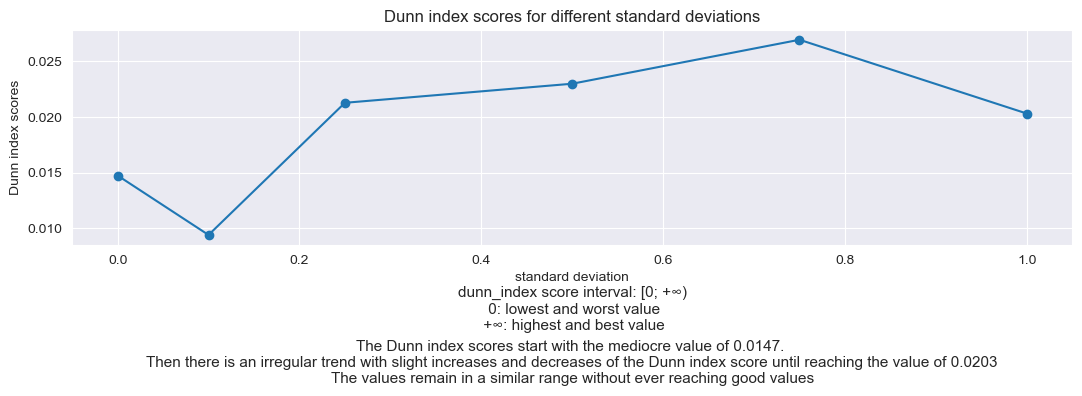

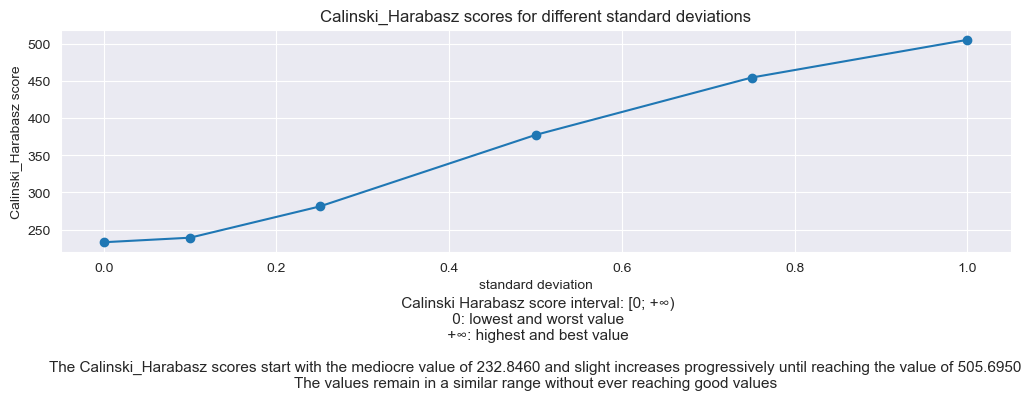

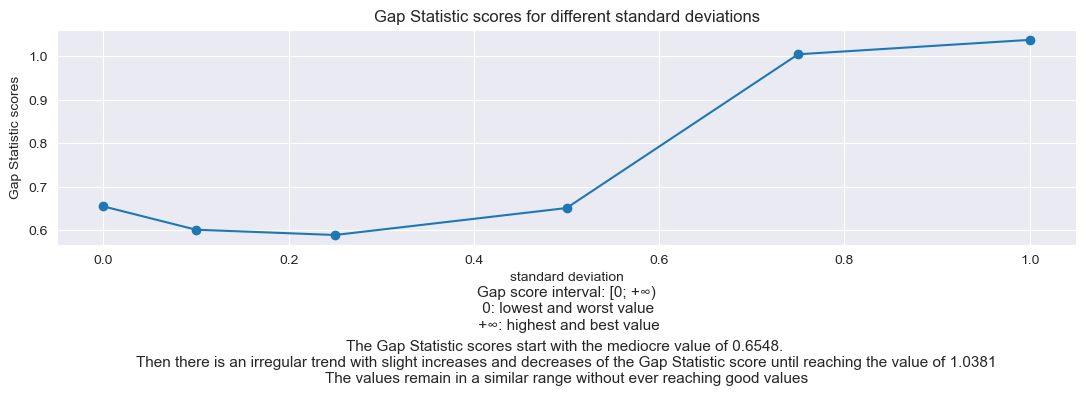

In [7]:
# Array for metric values
silhouette_scores = []  
entropy_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
dunn_index_scores = [] 
gap_scores = []


# standard deviation
sds = np.array([0, 0.1, 0.25, 0.5, 0.75, 1])
#[::-1]
#print(sds)

fig, axs = plt.subplots(6,2, figsize=(10,20))
sns.set_style("darkgrid")
fig.tight_layout()

r = 0
c = 0
c2= 1

for s in sds:
    #print(s)
    centers = np.array([[s,0],[0,0]])
    
    X, y = make_blobs(n_samples=[1000,10000], centers=centers, cluster_std=[0.25,1], random_state=0)
    
    cond1 = ((0.20**2 <= (X[:,0]-centers[0,0])**2 + (X[:,1] - centers[0,1])**2) & ((X[:,0]-centers[0,0])**2 + (X[:,1] - centers[0,1])**2 <= 0.25**2))
    cond2 = ((0.7**2 <=(X[:,0]-centers[1,0])**2 + (X[:,1] - centers[1,1])**2) & ((X[:,0]-centers[1,0])**2 + (X[:,1] - centers[1,1])**2 <= 0.75**2))
    X_temp = X[((y==0) & cond1) | ((y==1) & cond2)]
    y = y[((y==0) & cond1) | ((y==1) & cond2)]
    X = X_temp
    
    if r==0:
        scatter=sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[r,c])
        scatter.set_title('original point plots', fontsize=15)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[r,c])

    #axs[r,c].set_xticks([])
    #axs[r,c].set_yticks([])
    axs[r,c].get_legend().remove()
    
    data = pd.DataFrame(np.zeros((X.shape[0], 3)))
    data.iloc[:, [0,1]] = X
    data.iloc[:, 2] = y
    data.to_csv("cluster_" + str(s) + ".csv")

    km = KMeans(n_clusters=2, n_init=1, random_state=0)
    km.fit(X)
    l = km.labels_
    cs = km.cluster_centers_
    if cs[0,0] > cs[1,0]:
        l = [1 if x == 0 else 0 for x in l]
    
    # Silhouette calculation
    silhouette_avg = silhouette_score(X, l)
    silhouette_scores.append(silhouette_avg)
    #print(f"Silhouette Score for cluster_{s}: {silhouette_avg}")
    
    # Entropy calculation
    entropy_val = entropy(np.bincount(l) / len(l), base=2)
    entropy_scores.append(entropy_val)
    #print(f"Entropia Score for cluster_{s}: {entropy_val}")

    
    # Calinski-Harabasz index calculation
    calinski_harabasz_index = calinski_harabasz_score(X, l)
    calinski_harabasz_scores.append(calinski_harabasz_index)
    #print(f"Calinski-Harabasz Score for cluster_{s}: {calinski_harabasz_index}")

    
    # Davies-Bouldin calculation
    davies_bouldin_avg = davies_bouldin_score(X, l)
    davies_bouldin_scores.append(davies_bouldin_avg)
    #print(f"Davies-Bouldin Score for cluster_{s}: {davies_bouldin_avg}")
    
    # Dunn index calculation
    dunn_score = dunn_index(X, l)
    dunn_index_scores.append(dunn_score)
    
    optimal_k = OptimalK(parallel_backend='joblib')
    n_clusters = optimal_k(X, cluster_array=np.arange(1, 15))
    gap_df = optimal_k.gap_df
    optimal_gap_statistic = gap_df.loc[gap_df.gap_value.idxmax(), 'gap_value']
    gap_scores.append(optimal_gap_statistic)
    
    if r==0:
        scatter2=sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[r,c2])
        scatter2.set_title('plots clustered points with k-means', fontsize=15)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=l, ax=axs[r,c2])

    #axs[c,r].set_xticks([])
    #axs[c,r].set_yticks([])
    axs[r,c2].get_legend().remove()
    
    r=r+1 
        
#print metric arrays
print("Silhouette Scores:")
for score in silhouette_scores:
    print(score)

print("\nEntropy Scores:")
for score in entropy_scores:
    print(score)
    
print("\nCalinski Harabasz Scores:")
for score in calinski_harabasz_scores:
    print(score)

print("\nDavies-Bouldin Scores:")
for score in davies_bouldin_scores:
    print(score)
    
print("\nDunn-Index Scores:")
for score in dunn_index_scores:
    print(score)

print("\nGap Scores:")
for score in gap_scores:
    print(score)    
    
#print(optimal_k.gap_df .iloc[:,:3])

#save the values of the metrics in a txt file
with open("metrics_values.txt", "w") as file:
    file.write("Silhouette Scores:\n")
    for score in silhouette_scores:
        file.write(str(score) + "\n")

    file.write("\nEntropy Scores:\n")
    for score in entropy_scores:
        file.write(str(score) + "\n")

    file.write("\nCalinski Harabasz Scores:\n")
    for score in calinski_harabasz_scores:
        file.write(str(score) + "\n")

    file.write("\nDavies-Bouldin Scores:\n")
    for score in davies_bouldin_scores:
        file.write(str(score) + "\n")

    file.write("\nDunn-Index Scores:\n")
    for score in dunn_index_scores:
        file.write(str(score) + "\n")
    
    file.write("\nGap Scores:\n")
    for score in gap_scores:
        file.write(str(score) + "\n")

# Plot of Silhouette variations
plt.figure(figsize=(11, 5))
plt.plot(sds, silhouette_scores, marker='o')
plt.title('Silhouette scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Silhouette scores')
plt.grid(True)
plt.ylim(-1, 1)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_2/variazioni_Silhouette_2.png'
text = ' Silhoette score interval: [-1; +1]\n -1: lowest and worst value\n +1: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = 'The Silhoette score start with the mediocre value of '+ "{:.4f}".format(silhouette_scores[0]) + ' and slight increases progressively until reaching the value of '+ "{:.4f}".format(silhouette_scores[-1]) +'\nThe results indicate that there is a slight incresing of the quality of the cluster as the standard deviation increases but the values remain relatively mediocre'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()


# Plot of Entropy variations
plt.figure(figsize=(11, 5))
plt.plot(sds, entropy_scores, marker='o')
plt.title('Entropy scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Entropy scores')
plt.grid(True)
plt.ylim(0, 1.2)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_2/variazioni_Entropy_2.png'
text=' Entropy score interval: [0; +1]\n 0: lowest and worst value\n +1: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = 'The Entropy score remains practically constant as the standard deviation increases'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Davies_Bouldin variations
plt.figure(figsize=(11, 5))
plt.plot(sds, davies_bouldin_scores, marker='o')
plt.title('Davies_Bouldin scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Davies_Bouldin scores')
plt.grid(True)
plt.ylim(0, 1.5)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_2/variazioni_Davies_Bouldin_2.png'
text=' Davies_Bouldin score interval: [0; +∞)\n 0: lowest and best value\n +∞: highest and worst value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = 'The Davies_Bouldin scores start with the mediocre value of '+ "{:.4f}".format(davies_bouldin_scores[0]) + ' and slight decreases progressively until reaching the value of '+ "{:.4f}".format(davies_bouldin_scores[-1]) +'\nThe results indicate that there is a slight incresing of the quality of the cluster as the standard deviation increases but the values remain relatively mediocre'
plt.text(0.5, -0.5, text2, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Dunn index variations
plt.figure(figsize=(11, 5))
plt.plot(sds, dunn_index_scores, marker='o')
plt.title('Dunn index scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Dunn index scores')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_2/variazioni_dunn_index_2.png'
text = 'dunn_index score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
text2 = 'The Dunn index scores start with the mediocre value of '+ "{:.4f}".format(dunn_index_scores[0]) +'. \nThen there is an irregular trend with slight increases and decreases of the Dunn index score until reaching the value of '+ "{:.4f}".format(dunn_index_scores[-1])+'\nThe values remain in a similar range without ever reaching good values'
plt.text(0.5, -0.55, text2, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
plt.tight_layout()  
plt.savefig(file_path)
plt.show()

# Plot of Calinski_Harabasz variations
plt.figure(figsize=(11, 5))
plt.plot(sds, calinski_harabasz_scores, marker='o')
plt.title('Calinski_Harabasz scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Calinski_Harabasz score')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_2/variazioni_Calinski_Harabasz_2.png'
text=' Calinski Harabasz score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
text2 = 'The Calinski_Harabasz scores start with the mediocre value of '+ "{:.4f}".format(calinski_harabasz_scores[0]) +' and slight increases progressively until reaching the value of '+ "{:.4f}".format(calinski_harabasz_scores[-1])+'\nThe values remain in a similar range without ever reaching good values'
plt.text(0.5, -0.55, text2, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Gap Statistic variations
plt.figure(figsize=(11, 5))
plt.plot(sds, gap_scores, marker='o')
plt.title('Gap Statistic scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Gap Statistic scores')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_1/variazioni_gap_1.png'
text = 'Gap score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
text2 = 'The Gap Statistic scores start with the mediocre value of '+ "{:.4f}".format(gap_scores[0]) +'. \nThen there is an irregular trend with slight increases and decreases of the Gap Statistic score until reaching the value of '+ "{:.4f}".format(gap_scores[-1])+'\nThe values remain in a similar range without ever reaching good values'
plt.text(0.5, -0.55, text2, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

fig.savefig("circles2.png", facecolor="gray")

Silhouette Scores:
0.7450403412914528
0.5963958124942581
0.51413490715754
0.44631245813793
0.35728950995149905
0.3765254969733918

Entropy Scores:
0.9992887913246197
0.9999071196136652
0.9998651614008649
0.9999998393492914
0.9999272326511469
0.9999231367211181

Calinski Harabasz Scores:
6215.8919478717435
6196.957064163923
6157.880175251521
5819.470553512491
6008.262804891483
8269.052317125535

Davies-Bouldin Scores:
0.38952892331257605
0.6588287773931812
0.8163139347188646
0.9475763447447859
1.126205538796222
1.0444465059858181

Dunn-Index Scores:
0.813489592299246
0.33191037047843364
0.15211806592171948
0.029692179913230907
0.002390543006351328
0.0016534846579078406

Gap Scores:
1.4321831633443898
0.7592312466781603
0.47477299380641735
0.3298332619583588
0.2619541435859247
0.24541547157592447


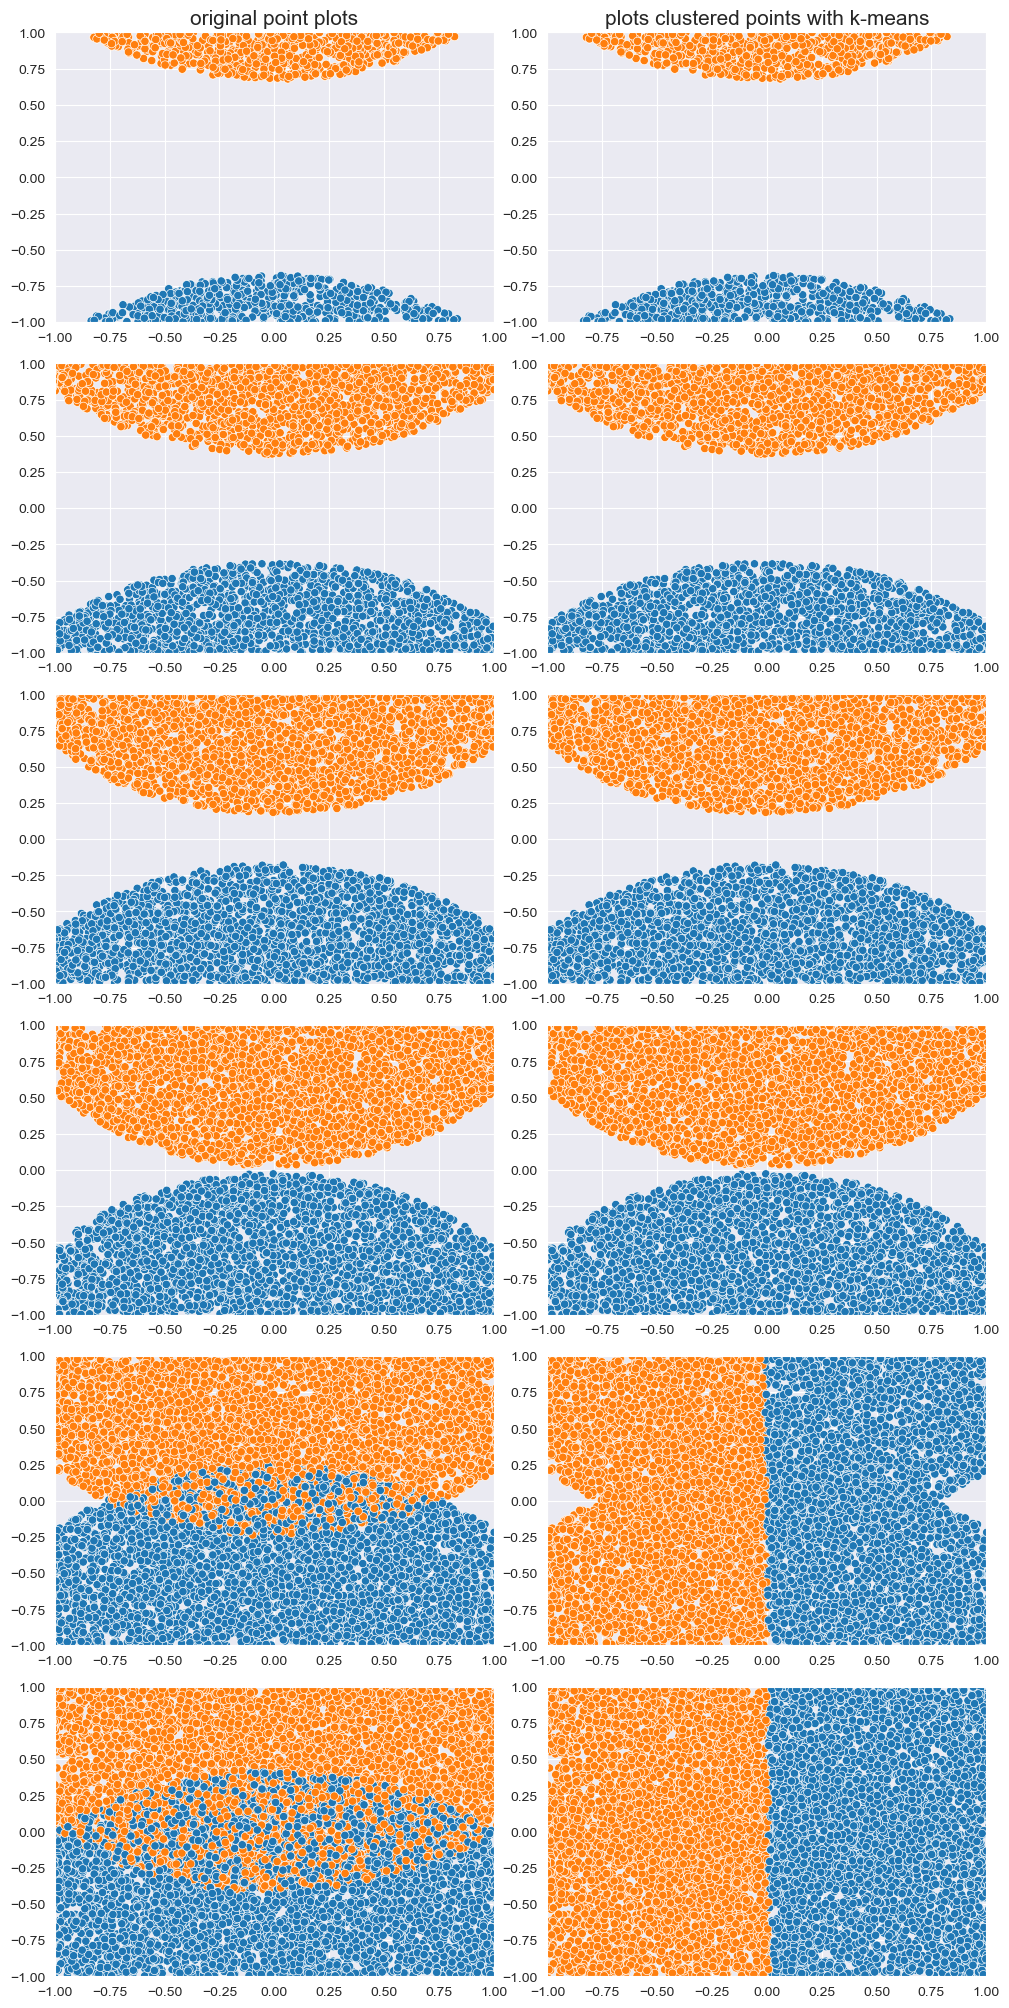

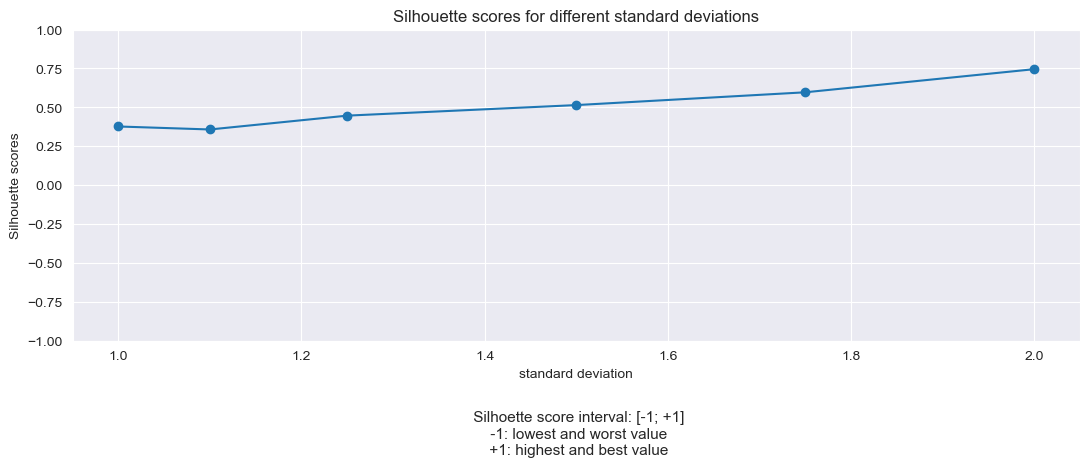

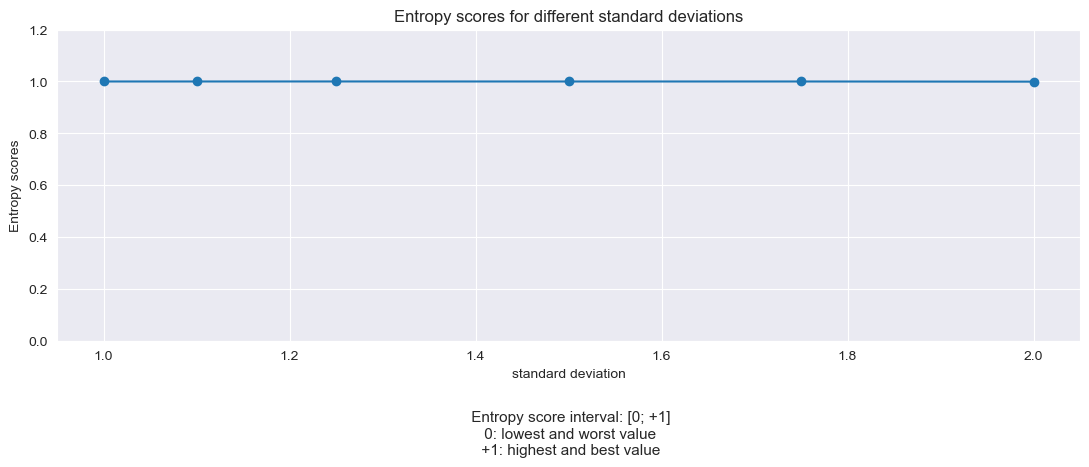

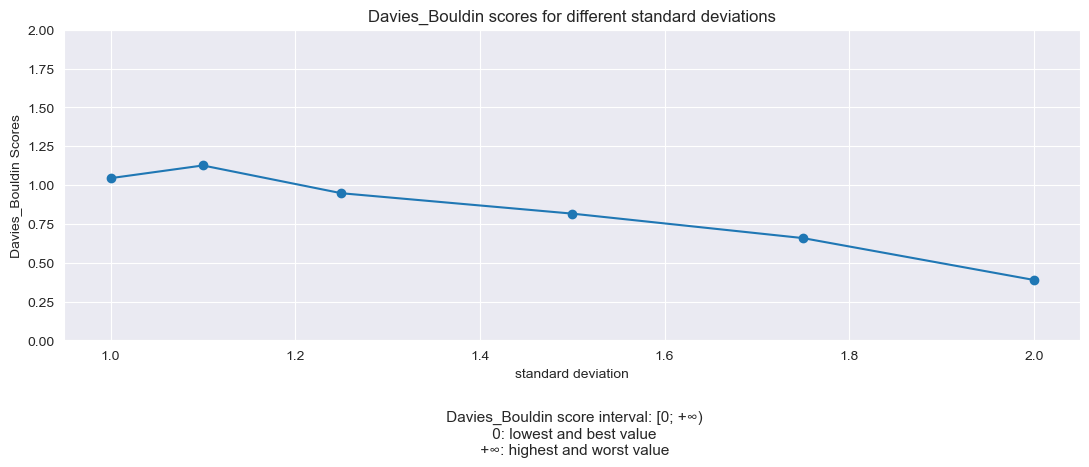

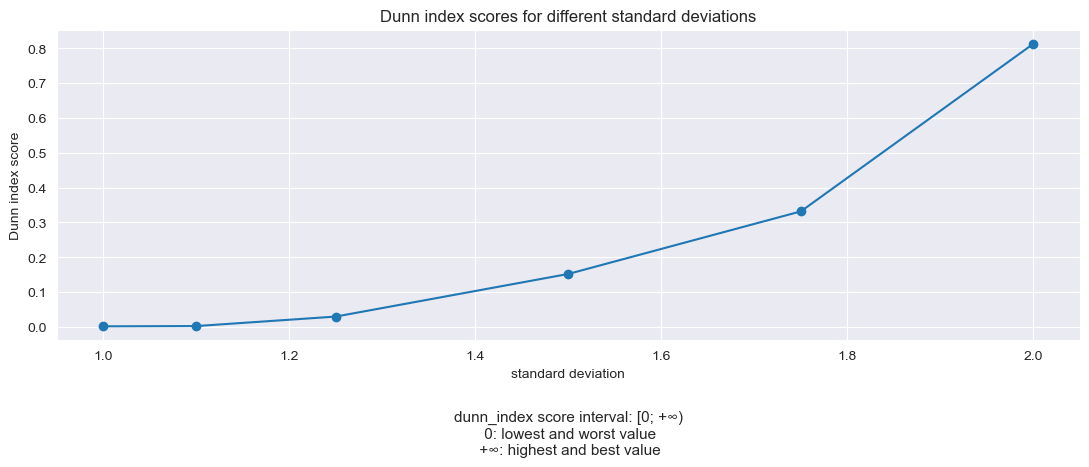

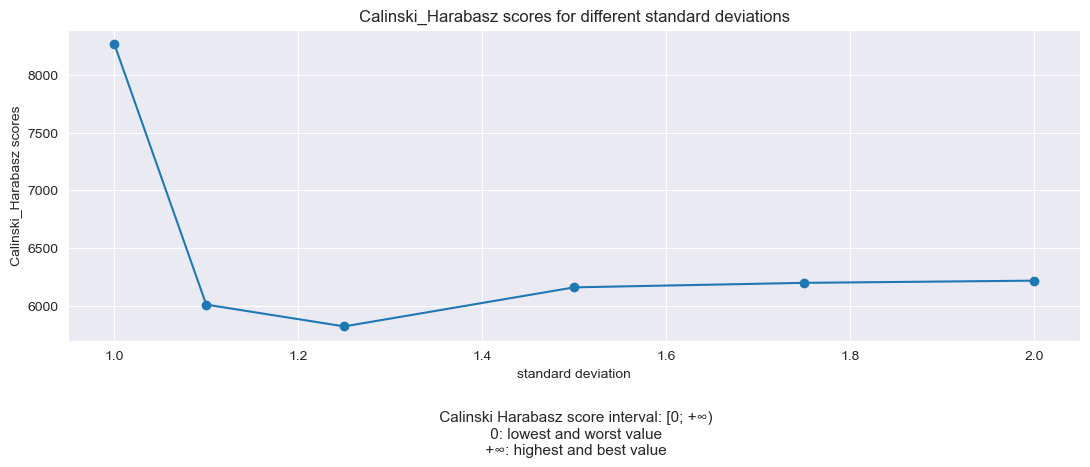

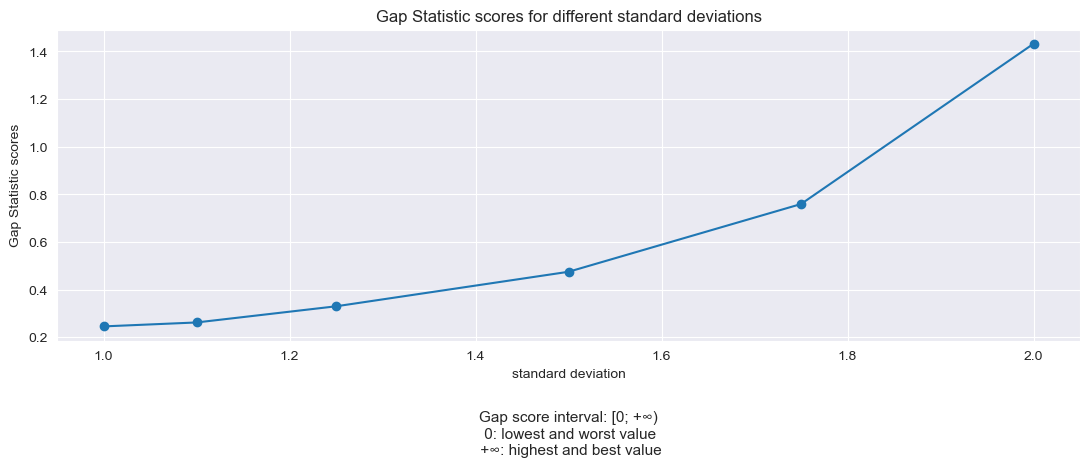

In [9]:
# Array for metric values
silhouette_scores = []  
entropy_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
dunn_index_scores = [] 
gap_scores = []

#standard deviation
cds = [2, 1.75, 1.5, 1.25, 1.1, 1]
rs = [1.75, 1.9, 1.75, 1.5, 1.8, 2]

fig, axs = plt.subplots(6,2, figsize=(10,20))
sns.set_style("darkgrid")
fig.tight_layout()


r = 0
c = 0
c2= 1

for i,s in enumerate(cds):
    centers = np.array([[0,-s],[0,s]])
    X, y = make_blobs(n_samples=100000, centers=centers, cluster_std=2)

    cond1 = (((X[:,0]-0)**2 + (X[:,1] - (-s))**2) <= rs[i])
    cond2 = (((X[:,0]-0)**2 + (X[:,1] - s)**2) <= rs[i])
    X_temp = X[(((cond1) & (y == 0)) | ((cond2) & (y == 1))) & (np.abs(X[:,1]) <= 1)]
    y = y[(((cond1) & (y == 0)) | ((cond2) & (y == 1))) & (np.abs(X[:,1]) <= 1)]
    X = X_temp

    if r==0:
        scatter=sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[r,c])
        scatter.set_title('original point plots', fontsize=15)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[r,c])


    axs[r,c].set_xlim(-1,1)
    axs[r,c].set_ylim(-1,1)
    #axs[r,c].set_xticks([])
    #axs[r,c].set_yticks([])
    axs[r,c].get_legend().remove()
    
    data = pd.DataFrame(np.zeros((X.shape[0], 3)))
    data.iloc[:, [0,1]] = X
    data.iloc[:, 2] = y
    data.iloc[:1000,:].to_csv("circles_cluster_" + str(s) + ".csv")

    km = KMeans(n_clusters=2, n_init=1, random_state=0)
    km.fit(X)
    l = km.labels_
    cs = km.cluster_centers_
    if cs[0,1] > cs[0,0]:
        l = [1 if x == 0 else 0 for x in l]
    
    # Silhouette calculation
    silhouette_avg = silhouette_score(X, l)
    silhouette_scores.append(silhouette_avg)
    
    # Entropy calculation
    entropy_val = entropy(np.bincount(l) / len(l), base=2)
    entropy_scores.append(entropy_val)
    
    # Calinski-Harabasz index calculation
    calinski_harabasz_index = calinski_harabasz_score(X, l)
    calinski_harabasz_scores.append(calinski_harabasz_index)
    
    # Davies-Bouldin calculation
    davies_bouldin_avg = davies_bouldin_score(X, l)
    davies_bouldin_scores.append(davies_bouldin_avg)
    
    # Dunn index calculation
    dunn_score = dunn_index(X, l)
    dunn_index_scores.append(dunn_score)
    
    # Gap Statistic calculation
    optimal_k = OptimalK(parallel_backend='joblib')
    n_clusters = optimal_k(X, cluster_array=np.arange(1, 15))
    gap_df = optimal_k.gap_df
    optimal_gap_statistic = gap_df.loc[gap_df.gap_value.idxmax(), 'gap_value']
    gap_scores.append(optimal_gap_statistic)
    
    if r==0:
        scatter2=sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=axs[r,c2])
        scatter2.set_title('plots clustered points with k-means', fontsize=15)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=l, ax=axs[r,c2])

    #axs[c,r].set_xticks([])
    #axs[c,r].set_yticks([])
    axs[r,c2].set_xlim(-1,1)
    axs[r,c2].set_ylim(-1,1)
    axs[r,c2].get_legend().remove()
    
    r += 1
    
# Print metric arrays
print("Silhouette Scores:")
for score in silhouette_scores:
    print(score)

print("\nEntropy Scores:")
for score in entropy_scores:
    print(score)
    
print("\nCalinski Harabasz Scores:")
for score in calinski_harabasz_scores:
    print(score)

print("\nDavies-Bouldin Scores:")
for score in davies_bouldin_scores:
    print(score)
    
print("\nDunn-Index Scores:")
for score in dunn_index_scores:
    print(score)

print("\nGap Scores:")
for score in gap_scores:
    print(score)    
    
#print(optimal_k.gap_df .iloc[:,:3])
    
#save the values of the metrics in a txt file
with open("metrics_values_3.txt", "w") as file:
    file.write("Silhouette Scores:\n")
    for score in silhouette_scores:
        file.write(str(score) + "\n")

    file.write("\nEntropy Scores:\n")
    for score in entropy_scores:
        file.write(str(score) + "\n")

    file.write("\nCalinski Harabasz Scores:\n")
    for score in calinski_harabasz_scores:
        file.write(str(score) + "\n")

    file.write("\nDavies-Bouldin Scores:\n")
    for score in davies_bouldin_scores:
        file.write(str(score) + "\n")

    file.write("\nDunn-Index Scores:\n")
    for score in dunn_index_scores:
        file.write(str(score) + "\n")
    
    file.write("\nGap Scores:\n")
    for score in gap_scores:
        file.write(str(score) + "\n")

# Plot of Silhouette variations
plt.figure(figsize=(11, 5))
plt.plot(cds, silhouette_scores, marker='o')
plt.title('Silhouette scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Silhouette scores')
plt.grid(True)
plt.ylim(-1, 1)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_3/variazioni_Silhouette_3.png'
text = ' Silhoette score interval: [-1; +1]\n -1: lowest and worst value\n +1: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()


# Plot of Entropy index variations
plt.figure(figsize=(11, 5))
plt.plot(cds, entropy_scores, marker='o')
plt.title('Entropy scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Entropy scores')
plt.grid(True)
plt.ylim(0, 1.2)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_3/variazioni_Entropy_3.png'
text=' Entropy score interval: [0; +1]\n 0: lowest and worst value\n +1: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Davies_Bouldin variations
plt.figure(figsize=(11, 5))
plt.plot(cds, davies_bouldin_scores, marker='o')
plt.title('Davies_Bouldin scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Davies_Bouldin Scores')
plt.grid(True)
plt.ylim(0, 2)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_3/variazioni_Davies_Bouldin_3.png'
text=' Davies_Bouldin score interval: [0; +∞)\n 0: lowest and best value\n +∞: highest and worst value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Dunn index variations
plt.figure(figsize=(11, 5))
plt.plot(cds, dunn_index_scores, marker='o')
plt.title('Dunn index scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Dunn index score')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_3/variazioni_dunn_index_3.png'
text = 'dunn_index score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)  # Modifica y per evitare sovrapposizione
plt.tight_layout()  # Utilizza tight_layout per regolare automaticamente i parametri della figura
plt.savefig(file_path)
plt.show()

# Plot of Calinski_Harabasz variations
plt.figure(figsize=(11, 5))
plt.plot(cds, calinski_harabasz_scores, marker='o')
plt.title('Calinski_Harabasz scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Calinski_Harabasz scores')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_3/variazioni_Calinski_Harabasz_3.png'
text=' Calinski Harabasz score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value'
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes,fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

# Plot of Gap Statistic variations
plt.figure(figsize=(11, 5))
plt.plot(cds, gap_scores, marker='o')
plt.title('Gap Statistic scores for different standard deviations')
plt.xlabel('standard deviation')
plt.ylabel('Gap Statistic scores')
plt.grid(True)
file_path = '/Users/andreaspagnolo/Desktop/uni/stage/result/result_data_1/variazioni_gap_1.png'
text = 'Gap score interval: [0; +∞)\n 0: lowest and worst value\n +∞: highest and best value' 
plt.text(0.5, -0.3, text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=11)
plt.tight_layout()
plt.savefig(file_path)
plt.show()

fig.savefig("semi_circles.png", facecolor="gray")